# ASSIGNMENT 2: DYNAMICS ON NETWORKS - THRESHOLDS AND SPREADING
## Unified Simulation Framework

**Course:** Model Based Decision-making (5404MBDM6Y)  
**Student:** 10205071  
**Date:** November 20, 2025

### Description
This notebook integrates graph ingestion (YouTube), Hub-and-Spoke sampling, Linear Threshold Model (LTM) simulation with 5 threshold distributions, and high-fidelity visualization into a single pipeline.

"**Note:** This notebook is adapted from and builds on methods and code in the following notebooks from week 3-dynamics on networks : \n",
  "- `Network_Topology_Spreading_Experiment.ipynb`\n",
  "- `Network_Robustness_Experiment.ipynb`\n",
  "- `Granovetter_Threshold_Experiments.ipynb`\n" by MH Lees publisched at https://github.com/mhlees/Model-Based-Decisions-Code

**Dependencies:** `networkx`, `matplotlib`, `pandas`, `numpy`, `scipy`, `gzip`

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import random
import os
import sys
import time
import gzip
import seaborn as sns
import matplotlib.colors as mcolors
from collections import defaultdict

In [37]:
# ==========================================
# CONFIGURATION & CONSTANTS
# ==========================================

# I/O Settings
INPUT_FILE = "com-youtube.ungraph.txt.gz"
OUTPUT_DIR = "simulation_outputs"
RESULTS_CSV = "monte_carlo_results.csv"
BC_FILE = "sampled_bc_exact.csv"

# Simulation Parameters
N_TARGET_SUBGRAPH = 2000    # Target size for the sampled subgraph
SEED_FRACTION = 0.01        # 1% of nodes to seed active
NUM_SIMULATIONS = 10        # R=10 (Default per assignment hint, validated by stats check)
MAX_STEPS = 50              # Guard clause for convergence

# Statistical Constants for Rigor Check
CONFIDENCE_LEVEL = 0.99 
Z_SCORE = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2) 
PRECISION_EPSILON = 0.01 

# Reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Module 1: Graph Ingestion & Sampling

In [38]:
def load_network_data(filepath):
    """
    Loads the network graph from an edge list file (supports .gz).
    Extracts Largest Connected Component (LCC).
    Falls back to Barabasi-Albert if file missing.
    """
    start_time = time.time()
    G = None
    
    if os.path.exists(filepath):
        print(f"[INFO] Reading edge list from {filepath}...")
        try:
            # Handle GZIP transparency
            if filepath.endswith('.gz'):
                with gzip.open(filepath, 'rt') as f:
                    G = nx.read_edgelist(f, nodetype=int, create_using=nx.Graph)
            else:
                G = nx.read_edgelist(filepath, nodetype=int, create_using=nx.Graph)
        except Exception as e:
            print(f"[WARN] Read failed ({e}). Generating synthetic proxy...")
            G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
    else:
        print(f"[WARN] File '{filepath}' not found.")
        print(f"[INFO] Generating synthetic Scale-Free proxy...")
        G = nx.barabasi_albert_graph(n=5000, m=3, seed=GLOBAL_SEED)
    
    # Extract LCC
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    elapsed = time.time() - start_time
    print(f"[INFO] LCC Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    print(f"[INFO] Load Time: {elapsed:.4f} seconds")
    return G

def hub_and_spoke_sampling(G_full, N_target=2000):
    """
    Creates a Hub-and-Spoke sample by selecting top hubs and their immediate neighbors.
    This preserves the Scale-Free core-periphery structure better than random sampling.
    """
    if G_full.number_of_nodes() <= N_target:
        return G_full

    print(f"[INFO] Executing Hub-and-Spoke Sampling (Target N={N_target})...")
    
    degree_map = dict(G_full.degree())
    sorted_hubs = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
    
    # Heuristic: Select top 5% as initial hubs
    k_H = max(10, int(len(G_full) * 0.05)) 
    hubs = set(sorted_hubs[:k_H])
    
    # Include Spokes (Neighbors of the Hubs)
    nodes_to_keep = set(hubs)
    for node in hubs:
        nodes_to_keep.update(G_full.neighbors(node))
        if len(nodes_to_keep) >= N_target * 1.5: # Optimization break
            break
            
    # If we have too many, trim by degree; if too few, keep all
    if len(nodes_to_keep) > N_target:
        # Prioritize keeping high degree nodes within the neighborhood
        subgraph_degrees = {n: degree_map[n] for n in nodes_to_keep}
        sorted_selection = sorted(subgraph_degrees, key=subgraph_degrees.get, reverse=True)
        nodes_to_keep = set(sorted_selection[:N_target])
        
    G_sampled = G_full.subgraph(nodes_to_keep).copy()
    
    # Tag nodes for visualization
    nx.set_node_attributes(G_sampled, {n: 'Hub' if n in hubs else 'Spoke' for n in G_sampled.nodes()}, 'role')
    
    print(f"[INFO] Sample Generated: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges.")
    return G_sampled

## Module 2: Centrality & Seeding

In [39]:
def precompute_centrality(G):
    """
    Calculates Betweenness Centrality on the sampled graph.
    Saves to CSV to demonstrate data persistence.
    Returns the map for simulation usage.
    """
    csv_path = os.path.join(OUTPUT_DIR, BC_FILE)
    print("[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...")
    start_t = time.time()
    
    bc_map = nx.betweenness_centrality(G, normalized=True, seed=GLOBAL_SEED)
    
    # Save to CSV
    df = pd.DataFrame(bc_map.items(), columns=['Node', 'Betweenness'])
    df = df.sort_values(by='Betweenness', ascending=False)
    df.to_csv(csv_path, index=False)
    
    print(f"[INFO] Centrality calculated in {time.time()-start_t:.2f}s. Saved to {csv_path}")
    return bc_map

def get_seeds(G, strategy, fraction, bc_map=None):
    """Selects seeds based on the specified strategy."""
    N = G.number_of_nodes()
    num_seeds = max(1, int(N * fraction))
    
    nodes = list(G.nodes())
    
    if strategy == 'Random':
        return random.sample(nodes, num_seeds)
    
    elif strategy == 'Degree':
        # Recalculate degree for the specific subgraph
        degree_map = dict(G.degree())
        sorted_nodes = sorted(degree_map.keys(), key=degree_map.get, reverse=True)
        return sorted_nodes[:num_seeds]
        
    elif strategy == 'Betweenness':
        if bc_map is None:
            # Fallback if not precomputed
            bc_map = nx.betweenness_centrality(G, normalized=True)
        # Sort using the precomputed map
        sorted_nodes = sorted(bc_map.keys(), key=lambda x: bc_map.get(x, 0), reverse=True)
        return sorted_nodes[:num_seeds]
        
    return []

## Module 3: Threshold Dynamics (LTM)

In [40]:
def get_thresholds(G, scenario_key):
    """
    Generates threshold values based on distributions.
    Supported keys:
      - 'Fixed_0.2'   : all thresholds = 0.2
      - 'Uniform'     : Uniform(0,1)
      - 'Beta_Low'    : Beta(2,5)
      - 'Beta_Mid'    : Beta(2,2)
      - 'Beta_High'   : Beta(5,2)
      - 'Normal'      : Normal(phi_mean, phi_std) clipped to [0,1]  (uses GLOBAL defaults)
      - 'Constant_0.4': constant 0.4
    Any unknown key falls back to constant 0.4.
    """
    # Optional parameters (use global defaults if available)
    phi_mean = globals().get('PHI_MEAN', 0.3)
    phi_std = globals().get('PHI_STD', 0.1)

    if scenario_key == 'Fixed_0.2':
        return {n: 0.2 for n in G.nodes()}

    if scenario_key == 'Uniform':
        return {n: float(np.random.uniform(0, 1)) for n in G.nodes()}

    if scenario_key == 'Beta_Low':
        return {n: float(np.random.beta(2, 5)) for n in G.nodes()}

    if scenario_key == 'Beta_Mid':
        return {n: float(np.random.beta(2, 2)) for n in G.nodes()}

    if scenario_key == 'Beta_High':
        return {n: float(np.random.beta(5, 2)) for n in G.nodes()}

    if scenario_key in ('Normal', 'normal'):
        vals = np.clip(np.random.normal(phi_mean, phi_std, len(G)), 0.0, 1.0)
        return {n: float(vals[i]) for i, n in enumerate(G.nodes())}

    if scenario_key in ('Constant_0.4', 'constant_0.4', 'Const_0.4'):
        return {n: 0.4 for n in G.nodes()}

    # Fallback: constant 0.4 (safe conservative default)
    return {n: 0.4 for n in G.nodes()}

def run_threshold_simulation(G, seeds, thresholds):
    """
    Executes one run of the Linear Threshold Model.
    Returns adoption history and final state stats.
    """
    # Initialization
    active_set = set(seeds)
    history = [len(active_set) / len(G)]
    
    # Pre-compute neighbors to speed up inner loop
    adj = {n: set(G.neighbors(n)) for n in G.nodes()}
    degrees = {n: len(adj[n]) for n in G.nodes()}
    
    for step in range(MAX_STEPS):
        newly_active = set()
        
        # Optimization: Check only inactive nodes connected to active ones
        # For density, iterating all inactive is safer for correctness
        inactive_nodes = [n for n in G.nodes() if n not in active_set]
        
        if not inactive_nodes:
            break
            
        for node in inactive_nodes:
            deg = degrees[node]
            if deg == 0: continue
            
            # Count active neighbors
            active_neighbors = len([nbr for nbr in adj[node] if nbr in active_set])
            influence = active_neighbors / deg
            
            if influence >= thresholds[node]:
                newly_active.add(node)
        
        if newly_active:
            active_set.update(newly_active)
            history.append(len(active_set) / len(G))
        else:
            # Convergence reached
            history.extend([history[-1]] * (MAX_STEPS - step - 1))
            break
            
    return history, len(active_set)

## Module 4: Execution & Stats

In [ ]:
def calculate_statistical_rigor(pilot_variances):
    """
    Calculates R_req for statistical rigor based on pilot data variance.
    Formula: R_req >= (Z * s0 / epsilon)^2
    Returns the maximum recommended runs across scenarios.
    """
    print("\n" + "="*40)
    print("STATISTICAL RIGOR CHECK")
    print("="*40)

    max_r_req = 0
    per_scenario = {}

    for scenario, s0 in pilot_variances.items():
        if s0 == 0:
            per_scenario[scenario] = 0.0
            continue
        r_req = (Z_SCORE * s0 / PRECISION_EPSILON) ** 2
        per_scenario[scenario] = r_req
        print(f"Scenario [{scenario}]: StdDev={s0:.4f} -> R_req >= {r_req:.1f}")
        max_r_req = max(max_r_req, r_req)

    print(f"\n[DECISION] Recommended Runs for {CONFIDENCE_LEVEL*100}% Confidence: {int(np.ceil(max_r_req))}")
    print(f"[ACTION] Using configured NUM_SIMULATIONS = {NUM_SIMULATIONS}")
    return max_r_req, per_scenario


def adaptive_execute_experiment_suite(G, bc_map, pilot_runs=10, max_total_runs=500, max_wall_time_seconds=600):
    """
    Run pilot_runs first (defaults to 10). Compute variance and recommended R_req,
    then run additional trials up to min(ceil(R_req), max_total_runs), but also
    cap additional runs based on estimated runtime derived from the pilot and
    available CPU cores (os.cpu_count()) using max_wall_time_seconds budget.
    Returns combined DataFrame of timeseries. Also saves aggregated teacher-style
    summary and pivot tables to OUTPUT_DIR for reporting.
    """
    strategies = ['Random', 'Degree', 'Betweenness']
    threshold_scenarios =   ['Fixed_0.2', 'Uniform', 'Beta_Low', 'Beta_Mid', 'Beta_High', 'Normal', 'Constant_0.4']

    if G is None:
        raise ValueError("Graph G must be provided")

    # seed-budget fallback used in aggregation when needed
    B = max(1, int(G.number_of_nodes() * SEED_FRACTION))

    results_data = []
    pilot_tracker = defaultdict(list)

    total_pilot_units = pilot_runs * len(threshold_scenarios) * len(strategies)
    print(f"\n[INFO] Starting PILOT: {pilot_runs} runs per setting -> {total_pilot_units} simulation units...")
    pilot_start = time.time()
    unit_counter = 0

    # --- PILOT PHASE ---
    for thresh_key in threshold_scenarios:
        for trial in range(pilot_runs):
            trial_seed = GLOBAL_SEED + (abs(hash(thresh_key)) % 1000) + trial * 1009
            random.seed(trial_seed); np.random.seed(trial_seed)
            thresholds = get_thresholds(G, thresh_key)

            for strat in strategies:
                seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)
                curve, _ = run_threshold_simulation(G, seeds, thresholds)
                final_frac = float(curve[-1])
                pilot_tracker[f"{strat}_{thresh_key}"].append(final_frac)

                arr = np.array(curve)
                changes = np.where(np.diff(arr) != 0)[0]
                time_to_converge = int(changes[-1] + 1) if len(changes) else 0

                for t, val in enumerate(curve):
                    results_data.append({
                        'Trial': trial,
                        'Strategy': strat,
                        'Threshold_Dist': thresh_key,
                        'Step': int(t),
                        'Adoption_Fraction': float(val),
                        'Final_Fraction': final_frac,
                        'TimeToConverge': time_to_converge,
                        'SeedsCount': len(seeds)
                    })

                unit_counter += 1
                if unit_counter % 50 == 0:
                    print(f" -> Completed {unit_counter}/{total_pilot_units} pilot simulation units...")

    pilot_elapsed = time.time() - pilot_start
    time_per_unit = pilot_elapsed / max(1, total_pilot_units)
    cores = os.cpu_count() or 1

    # Compute pilot variances and recommended runs
    variances = {k: np.std(v, ddof=0) for k, v in pilot_tracker.items()}
    max_r_req, per_scenario = calculate_statistical_rigor(variances)

    # Decide target trials-per-setting (R_req rounded up), but respect max_total_runs cap
    recommended_total_per_setting = int(np.ceil(max_r_req))
    target_total_per_setting = max(pilot_runs, min(recommended_total_per_setting, max_total_runs))

    # Time-based cap: how many additional simulation-units can we do within max_wall_time_seconds
    # (we assume we could parallelize across 'cores' workers)
    max_additional_units_time = int((max_wall_time_seconds * cores) / max(1e-9, time_per_unit))
    # Convert unit-cap to trials-per-setting cap
    units_per_setting = len(threshold_scenarios) * len(strategies)
    additional_runs_time_cap = max(0, max_additional_units_time // units_per_setting - pilot_runs)
    # Final additional runs to execute (per setting)
    additional_runs_requested = max(0, target_total_per_setting - pilot_runs)
    additional_runs = min(additional_runs_requested, additional_runs_time_cap)

    print(f"\n[INFO] Pilot elapsed {pilot_elapsed:.1f}s -> ~{time_per_unit:.3f}s per simulation unit (cores={cores})")
    print(f"[INFO] Recommended trials-per-setting = {recommended_total_per_setting}, target (capped) = {target_total_per_setting}")
    print(f"[INFO] Time-budget allows ~{additional_runs_time_cap} additional trials-per-setting; executing {additional_runs} additional trials-per-setting.")

    if additional_runs <= 0:
        print("[INFO] No additional runs scheduled (time/cap reached). Proceeding to aggregation and return pilot results.")
        df_ts = pd.DataFrame(results_data)
        # perform aggregation & pivots (teacher-style) and save
        final_per_trial = df_ts.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False).agg(
            Final_Fraction=('Final_Fraction', 'max'),
            TimeToConverge=('TimeToConverge', 'max'),
            SeedsCount=('SeedsCount', 'max')
        )

        agg = final_per_trial.groupby(['Strategy', 'Threshold_Dist'], as_index=False).agg(
            n_runs=('Final_Fraction', 'count'),
            FinalAdoption=('Final_Fraction', 'mean'),
            Final_STD=('Final_Fraction', 'std'),
            CascadeProb=('Final_Fraction', lambda x: np.mean(np.array(x) >= 0.5)),
            Time50=('TimeToConverge', 'mean'),
            Seeds=('SeedsCount', lambda x: int(x.mode().iloc[0]) if len(x) > 0 else B)
        )
        agg['Efficiency'] = agg['FinalAdoption'] / agg['Seeds'].replace(0, 1)

        os.makedirs(OUTPUT_DIR, exist_ok=True)
        agg_path = os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv")
        agg.to_csv(agg_path, index=False)
        print(f"[INFO] Saved aggregated teacher-style summary to {agg_path}")

        # pivots
        try:
            pivot_final = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='FinalAdoption', aggfunc='mean')
            pivot_final.to_csv(os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"))
            print(f"[INFO] Saved pivot_final_adoption.csv")
        except Exception:
            pass

        try:
            pivot_cascade = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='CascadeProb', aggfunc='mean')
            pivot_cascade.to_csv(os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"))
            print(f"[INFO] Saved pivot_cascade_prob.csv")
        except Exception:
            pass

        try:
            pivot_eff = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='Efficiency', aggfunc='mean')
            pivot_eff.to_csv(os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"))
            print(f"[INFO] Saved pivot_efficiency.csv")
        except Exception:
            pass

        det_path = os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv")
        final_per_trial.to_csv(det_path, index=False)
        print(f"[INFO] Saved detailed per-trial summary to {det_path}")

        return df_ts

    # --- ADDITIONAL RUNS PHASE ---
    print(f"\n[INFO] Running additional {additional_runs} runs per setting (may take time)...")
    pbar2 = 0
    for extra in range(additional_runs):
        trial = pilot_runs + extra
        for thresh_key in threshold_scenarios:
            trial_seed = GLOBAL_SEED + (abs(hash(thresh_key)) % 1000) + trial * 1009
            random.seed(trial_seed); np.random.seed(trial_seed)
            thresholds = get_thresholds(G, thresh_key)

            for strat in strategies:
                seeds = get_seeds(G, strat, SEED_FRACTION, bc_map)
                curve, _ = run_threshold_simulation(G, seeds, thresholds)
                final_frac = float(curve[-1])

                arr = np.array(curve)
                changes = np.where(np.diff(arr) != 0)[0]
                time_to_converge = int(changes[-1] + 1) if len(changes) else 0

                for t, val in enumerate(curve):
                    results_data.append({
                        'Trial': trial,
                        'Strategy': strat,
                        'Threshold_Dist': thresh_key,
                        'Step': int(t),
                        'Adoption_Fraction': float(val),
                        'Final_Fraction': final_frac,
                        'TimeToConverge': time_to_converge,
                        'SeedsCount': len(seeds)
                    })

                pilot_tracker[f"{strat}_{thresh_key}"].append(final_frac)  # keep variance updated

                pbar2 += 1
                if pbar2 % 50 == 0:
                    total_add_units = additional_runs * len(threshold_scenarios) * len(strategies)
                    print(f" -> Completed {pbar2}/{total_add_units} additional simulation units...")

    # Final aggregation & save pivot tables
    df_ts = pd.DataFrame(results_data)

    final_per_trial = df_ts.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False).agg(
        Final_Fraction=('Final_Fraction', 'max'),
        TimeToConverge=('TimeToConverge', 'max'),
        SeedsCount=('SeedsCount', 'max')
    )

    agg = final_per_trial.groupby(['Strategy', 'Threshold_Dist'], as_index=False).agg(
        n_runs=('Final_Fraction', 'count'),
        FinalAdoption=('Final_Fraction', 'mean'),
        Final_STD=('Final_Fraction', 'std'),
        CascadeProb=('Final_Fraction', lambda x: np.mean(np.array(x) >= 0.5)),
        Time50=('TimeToConverge', 'mean'),
        Seeds=('SeedsCount', lambda x: int(x.mode().iloc[0]) if len(x) > 0 else B)
    )
    agg['Efficiency'] = agg['FinalAdoption'] / agg['Seeds'].replace(0, 1)

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    agg_path = os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv")
    agg.to_csv(agg_path, index=False)
    print(f"[INFO] Saved aggregated teacher-style summary to {agg_path}")

    # Pivot tables (Strategy x Threshold)
    try:
        pivot_final = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='FinalAdoption', aggfunc='mean')
        pivot_final.to_csv(os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"))
        print(f"[INFO] Saved pivot_final_adoption.csv")
    except Exception:
        pass

    try:
        pivot_cascade = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='CascadeProb', aggfunc='mean')
        pivot_cascade.to_csv(os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"))
        print(f"[INFO] Saved pivot_cascade_prob.csv")
    except Exception:
        pass

    try:
        pivot_eff = agg.pivot_table(index='Strategy', columns='Threshold_Dist', values='Efficiency', aggfunc='mean')
        pivot_eff.to_csv(os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"))
        print(f"[INFO] Saved pivot_efficiency.csv")
    except Exception:
        pass

    det_path = os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv")
    final_per_trial.to_csv(det_path, index=False)
    print(f"[INFO] Saved detailed per-trial summary to {det_path}")

    # Final variance report
    final_variances = {k: np.std(v, ddof=0) for k, v in pilot_tracker.items()}
    print("\n[INFO] Final variance estimates after adaptive runs:")
    for k, v in final_variances.items():
        print(f"  {k}: std={v:.4f}")
    calculate_statistical_rigor(final_variances)

    return df_ts


# Thin wrapper to preserve call sites and provide automatic time-based capping
def execute_experiment_suite(G, bc_map, B=None):
    """
    Backwards-compatible entrypoint. Runs adaptive scheme:
      - pilot of NUM_SIMULATIONS (default 10)
      - compute required R_req and run additional trials up to time/cap limits
    Returns DataFrame of per-step timeseries (same as previous usage).
    """
    # Tunable caps (trials per setting)
    MAX_TOTAL_TRIALS_PER_SETTING = 500
    # Wall-time budget in seconds used to estimate feasible additional runs (default 10 minutes)
    MAX_WALL_TIME_SECONDS = 600

    return adaptive_execute_experiment_suite(G, bc_map,
                                            pilot_runs=NUM_SIMULATIONS,
                                            max_total_runs=MAX_TOTAL_TRIALS_PER_SETTING,
                                            max_wall_time_seconds=MAX_WALL_TIME_SECONDS)

## Module 5: Visualization

In [42]:
def visualize_network_structure(G):
    """
    Visualizes the Hub-and-Spoke topology.
    Nodes colored by Role (Hub/Spoke), sized by Degree.
    """
    if len(G) > 3000:
        print("[WARN] Graph too large to plot cleanly. Skipping.")
        return

    print("\n[INFO] Generating Network Topology Plot...")
    plt.figure(figsize=(12, 12))
    
    pos = nx.spring_layout(G, k=0.10, seed=GLOBAL_SEED)
    
    # Attributes
    roles = nx.get_node_attributes(G, 'role')
    degrees = dict(G.degree())
    
    # Separate lists
    hubs = [n for n, r in roles.items() if r == 'Hub']
    spokes = [n for n, r in roles.items() if r != 'Hub']
    
    # Draw Spokes
    nx.draw_networkx_nodes(G, pos, nodelist=spokes, node_size=15, 
                          node_color='#4682B4', alpha=0.4, label='Spokes')
    
    # Draw Hubs (Sized by degree)
    hub_sizes = [degrees[n] * 3 for n in hubs]
    nx.draw_networkx_nodes(G, pos, nodelist=hubs, node_size=hub_sizes, 
                          node_color='#DC143C', alpha=0.9, label='Hubs')
    
    nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color='gray')
    
    plt.title(f"YouTube Hub-and-Spoke Sample (N={len(G)})", fontsize=15)
    plt.legend(loc='upper right')
    plt.axis('off')
    
    out_path = os.path.join(OUTPUT_DIR, "network_topology.png")
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[INFO] Saved topology plot to {out_path}")


def plot_comparative_curves(df):
    """
    Combined plotting utility:
      - mean ± CI multi-panel adoption curves per Threshold scenario (forward-filled to MAX_STEPS)
      - boxplots of Final_Fraction by Strategy x Scenario
      - boxplots of TimeToConverge by Strategy x Scenario
      - saves summary CSV with aggregated stats
    Assumes globals: MAX_STEPS, CONFIDENCE_LEVEL, NUM_SIMULATIONS, OUTPUT_DIR, sns, st, np, plt, os
    """
    print("[INFO] Generating Comparative Adoption Curves and Diagnostics (combined)...")

    # Ensure expected dtypes
    df = df.copy()
    df['Step'] = df['Step'].astype(int)

    # Canonical ordering
    scenarios = sorted(df['Threshold_Dist'].unique())
    strategies = ['Random', 'Degree', 'Betweenness']

    steps = list(range(MAX_STEPS))
    z = st.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2)

    # Precompute grouped stats per Strategy x Scenario x Step
    grouped = df.groupby(['Strategy', 'Threshold_Dist', 'Step'])['Adoption_Fraction'].agg(['mean', 'std', 'count']).reset_index()

    # Prepare figure for mean ± CI curves
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    axes = axes.flatten()
    styles = {'Random': ':', 'Degree': '--', 'Betweenness': '-'}
    palette_map = dict(zip(strategies, sns.color_palette("tab10", len(strategies))))

    for idx, scenario in enumerate(scenarios):
        ax = axes[idx]
        for strat in strategies:
            sub = grouped[(grouped['Threshold_Dist'] == scenario) & (grouped['Strategy'] == strat)].set_index('Step')
            # build arrays for all steps, forward-fill missing
            means, lo_ci, hi_ci = [], [], []
            prev_mean = 0.0
            for s in steps:
                if s in sub.index:
                    row = sub.loc[s]
                    mean = float(row['mean'])
                    n = int(row['count'])
                    std = float(row['std']) if n > 1 and not np.isnan(row['std']) else 0.0
                    sem = std / np.sqrt(n) if n > 0 else 0.0
                    ci_half = z * sem
                    lo = mean - ci_half
                    hi = mean + ci_half
                else:
                    # forward-fill using last known mean
                    mean = prev_mean
                    lo = prev_mean
                    hi = prev_mean
                mean = float(np.clip(mean, 0.0, 1.0))
                lo = float(np.clip(lo, 0.0, 1.0))
                hi = float(np.clip(hi, 0.0, 1.0))
                means.append(mean); lo_ci.append(lo); hi_ci.append(hi)
                prev_mean = mean

            ax.plot(steps, means, label=strat, linestyle=styles.get(strat, '-'),
                    color=palette_map[strat], lw=2)
            ax.fill_between(steps, lo_ci, hi_ci, color=palette_map[strat], alpha=0.15)

        ax.set_title(f"Scenario: {scenario}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Time Step")
        if idx % 3 == 0:
            ax.set_ylabel("Adoption Fraction")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.0)
        if idx == 0:
            ax.legend(title="Seeding Strategy", loc='lower right')

    # hide any unused subplots
    for j in range(len(scenarios), len(axes)):
        axes[j].axis('off')

    plt.suptitle("Dynamics of Contagion: Strategy vs. Threshold Heterogeneity (mean ± CI)", fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_path = os.path.join(OUTPUT_DIR, "adoption_curves_comparison_fixed.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[INFO] Saved mean+CI curves to {out_path}")

    # Boxplot: Final fraction per Strategy x Scenario
    if 'Final_Fraction' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Threshold_Dist', y='Final_Fraction', hue='Strategy', palette="Set2",
                    order=scenarios, hue_order=strategies)
        plt.title("Final Adoption Fraction by Threshold Scenario and Seeding Strategy")
        plt.xlabel("Threshold Distribution")
        plt.ylabel("Final Adoption Fraction")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "boxplot_final_fraction.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        print(f"[INFO] Saved boxplot final fractions to {out_path}")
    else:
        print("[WARN] 'Final_Fraction' column missing: skipping final fraction boxplot")

    # Boxplot: Time to Convergence
    if 'TimeToConverge' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Threshold_Dist', y='TimeToConverge', hue='Strategy', palette="Set3",
                    order=scenarios, hue_order=strategies)
        plt.title("Time to Convergence (last change) by Threshold Scenario & Strategy")
        plt.xlabel("Threshold Distribution")
        plt.ylabel("Time to Convergence (steps)")
        plt.legend(loc='upper right')
        out_path = os.path.join(OUTPUT_DIR, "time_to_converge.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        print(f"[INFO] Saved time-to-convergence plot to {out_path}")
    else:
        print("[WARN] 'TimeToConverge' column missing: skipping time-to-convergence plot")

    # Summary table (aggregated stats) saved
    # handle missing columns gracefully
    value_col = 'Final_Fraction' if 'Final_Fraction' in df.columns else 'Adoption_Fraction'
    time_col = 'TimeToConverge' if 'TimeToConverge' in df.columns else None

    agg_dict = {
        'Final_Mean': (value_col, 'mean'),
        'Final_STD': (value_col, 'std'),
    }
    if time_col:
        agg_dict.update({'TimeToConv_Mean': (time_col, 'mean'), 'TimeToConv_STD': (time_col, 'std')})
    else:
        agg_dict.update({'TimeToConv_Mean': ('Step', 'max'), 'TimeToConv_STD': ('Step', 'max')})

    summary_table = df.groupby(['Strategy', 'Threshold_Dist']).agg(**agg_dict).reset_index()
    summary_csv = os.path.join(OUTPUT_DIR, "summary_stats_by_strategy_threshold.csv")
    summary_table.to_csv(summary_csv, index=False)
    print(f"[INFO] Saved summary table to {summary_csv}")

In [ ]:
def create_summary_tables(df, out_dir=OUTPUT_DIR):
    """
    Create CSV tables useful for the report:
      - aggregated summary by Strategy x Threshold_Dist (mean, std, median, q25, q75, n)
      - ranking per Threshold_Dist by mean final adoption
      - per-trial detailed summary (Trial, Strategy, Threshold_Dist, Final_Fraction, TimeToConverge)
    """
    os.makedirs(out_dir, exist_ok=True)

    # Ensure we have Final_Fraction per trial
    if 'Final_Fraction' not in df.columns:
        final = df.groupby(['Trial', 'Strategy', 'Threshold_Dist'], as_index=False)['Adoption_Fraction'].last()
        final = final.rename(columns={'Adoption_Fraction': 'Final_Fraction'})
    else:
        final = df[['Trial', 'Strategy', 'Threshold_Dist', 'Final_Fraction', 'TimeToConverge']].drop_duplicates()

    det_path = os.path.join(out_dir, "detailed_per_trial_summary.csv")
    final.to_csv(det_path, index=False)

    # Aggregated summary with descriptive stats (keeps your original format)
    agg = final.groupby(['Strategy', 'Threshold_Dist']).agg(
        n_runs=('Final_Fraction', 'count'),
        mean_final=('Final_Fraction', 'mean'),
        std_final=('Final_Fraction', 'std'),
        median_final=('Final_Fraction', 'median'),
        q25_final=('Final_Fraction', lambda x: np.percentile(x, 25)),
        q75_final=('Final_Fraction', lambda x: np.percentile(x, 75)),
        mean_time_to_conv=('TimeToConverge', 'mean'),
        std_time_to_conv=('TimeToConverge', 'std')
    ).reset_index()

    agg_path = os.path.join(out_dir, "aggregated_summary_by_strategy_threshold.csv")
    agg.to_csv(agg_path, index=False)

    # Ranking per threshold scenario (teacher-inspired)
    ranks = agg.sort_values(['Threshold_Dist', 'mean_final'], ascending=[True, False])
    rank_path = os.path.join(out_dir, "ranking_by_threshold.csv")
    ranks.to_csv(rank_path, index=False)

    print(f"[INFO] Saved detailed ({det_path}), aggregated ({agg_path}), ranking ({rank_path})")
    return {'detailed': det_path, 'aggregated': agg_path, 'ranking': rank_path}



## Main Controller

In [44]:
# 1. Load & Sample
G_raw = load_network_data(INPUT_FILE)
G_sample = hub_and_spoke_sampling(G_raw, N_TARGET_SUBGRAPH)

[WARN] File 'com-youtube.ungraph.txt.gz' not found.
[INFO] Generating synthetic Scale-Free proxy...
[INFO] LCC Loaded: 5000 nodes, 14991 edges.
[INFO] Load Time: 0.0568 seconds
[INFO] Executing Hub-and-Spoke Sampling (Target N=2000)...
[INFO] Sample Generated: 2000 nodes, 5608 edges.


In [45]:
# 2. Pre-compute Centrality (Optimization)
bc_map = precompute_centrality(G_sample)

[INFO] Calculating EXACT Betweenness Centrality (this may take a moment)...


[INFO] Centrality calculated in 15.29s. Saved to simulation_outputs\sampled_bc_exact.csv


In [46]:
# 3. Visualize Topology
visualize_network_structure(G_sample)


[INFO] Generating Network Topology Plot...
[INFO] Saved topology plot to simulation_outputs\network_topology.png


In [47]:
# 4. Execute Simulations
df_results = execute_experiment_suite(G_sample, bc_map)



[INFO] Starting PILOT: 10 runs per setting -> 150 simulation units...
 -> Completed 50/150 pilot simulation units...
 -> Completed 100/150 pilot simulation units...
 -> Completed 150/150 pilot simulation units...

STATISTICAL RIGOR CHECK
Scenario [Random_Fixed_0.2]: StdDev=0.2791 -> R_req >= 5170.2
Scenario [Random_Uniform]: StdDev=0.0282 -> R_req >= 52.9
Scenario [Degree_Uniform]: StdDev=0.0554 -> R_req >= 203.6
Scenario [Betweenness_Uniform]: StdDev=0.0568 -> R_req >= 214.2
Scenario [Random_Beta_Low]: StdDev=0.2869 -> R_req >= 5461.9
Scenario [Degree_Beta_Low]: StdDev=0.0003 -> R_req >= 0.0
Scenario [Betweenness_Beta_Low]: StdDev=0.0003 -> R_req >= 0.0
Scenario [Random_Beta_Mid]: StdDev=0.0037 -> R_req >= 0.9
Scenario [Degree_Beta_Mid]: StdDev=0.0437 -> R_req >= 126.6
Scenario [Betweenness_Beta_Mid]: StdDev=0.0547 -> R_req >= 198.4
Scenario [Random_Beta_High, Normal, Constant_0.4]: StdDev=0.0010 -> R_req >= 0.1
Scenario [Degree_Beta_High, Normal, Constant_0.4]: StdDev=0.0000 -> R_re

[INFO] Raw data saved to simulation_outputs\monte_carlo_results.csv
[INFO] Saved detailed (simulation_outputs\detailed_per_trial_summary.csv), aggregated (simulation_outputs\aggregated_summary_by_strategy_threshold.csv), ranking (simulation_outputs\ranking_by_threshold.csv)
[INFO] Generating Comparative Adoption Curves and Diagnostics (combined)...


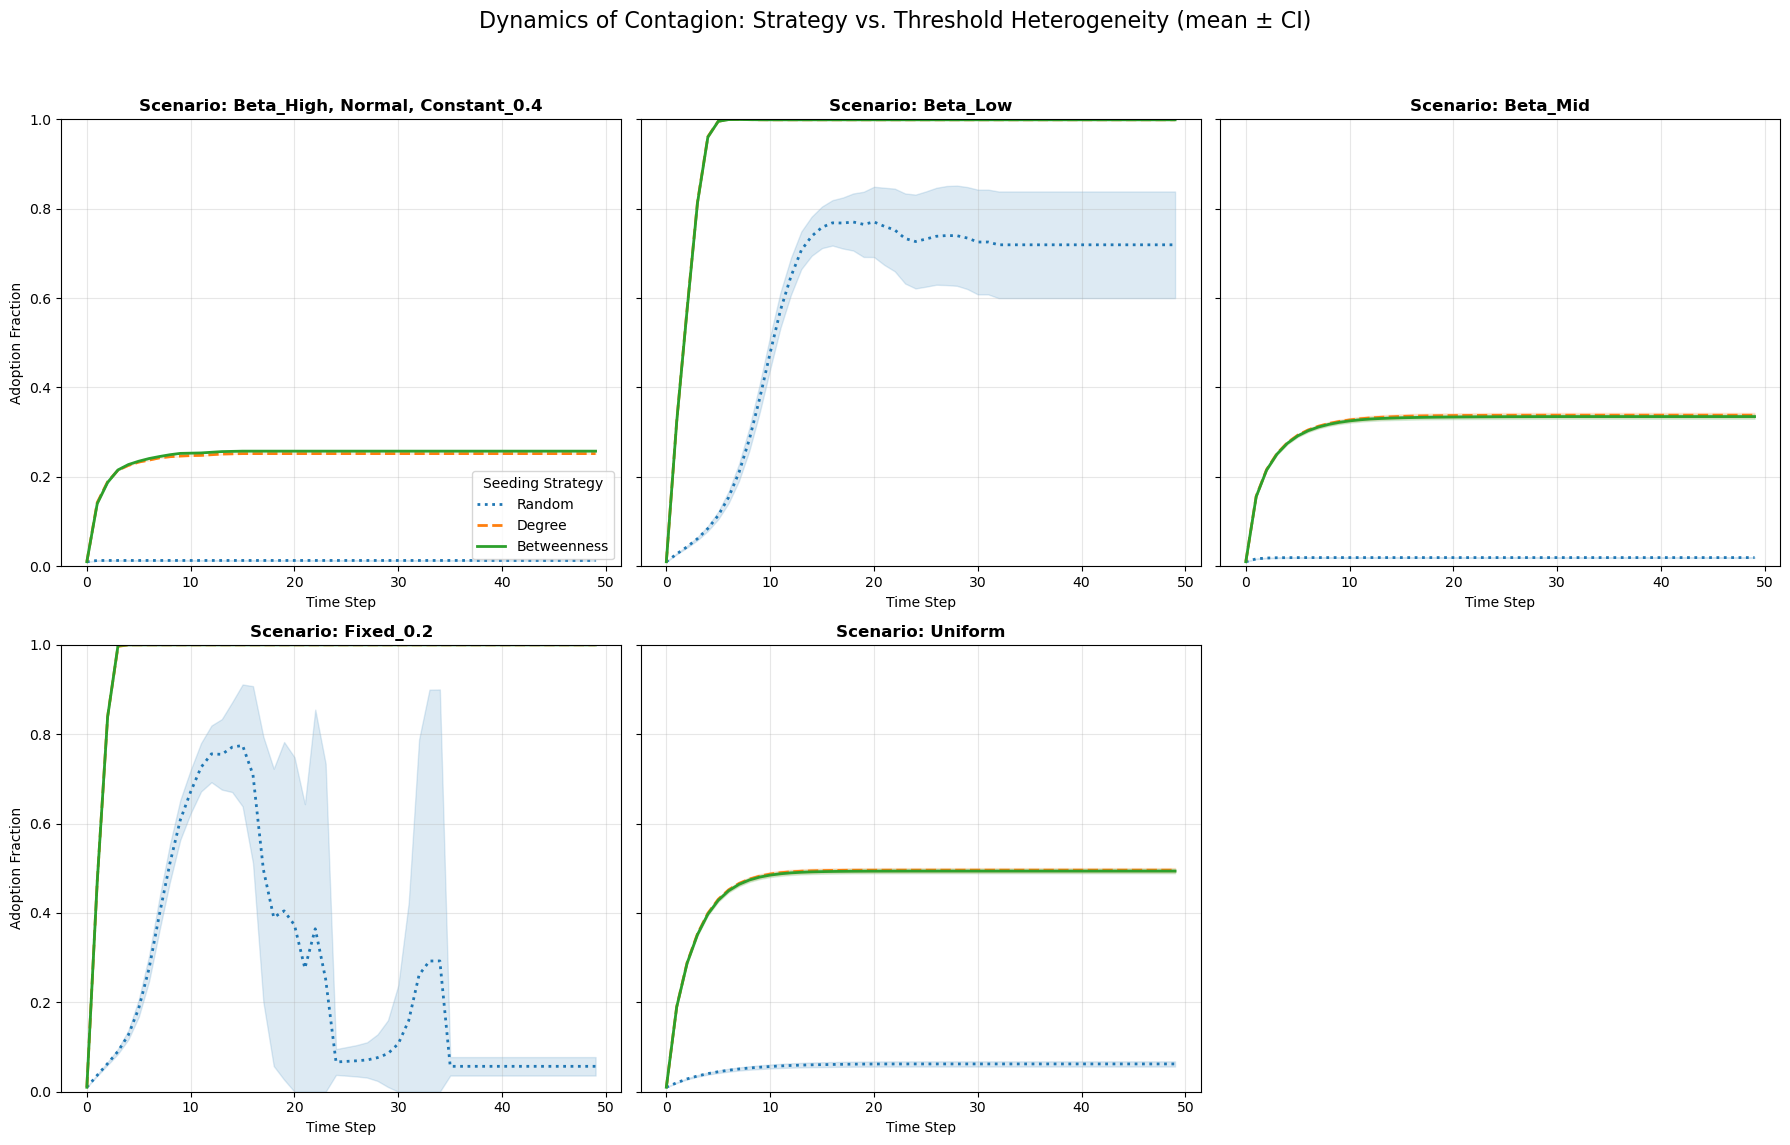

[INFO] Saved mean+CI curves to simulation_outputs\adoption_curves_comparison_fixed.png


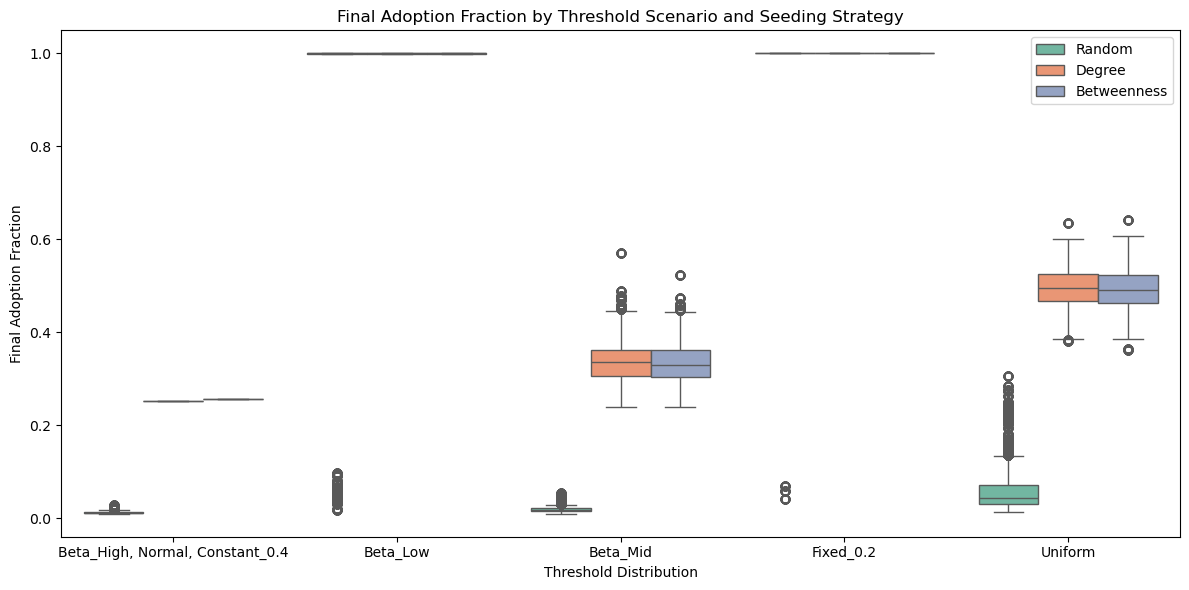

[INFO] Saved boxplot final fractions to simulation_outputs\boxplot_final_fraction.png


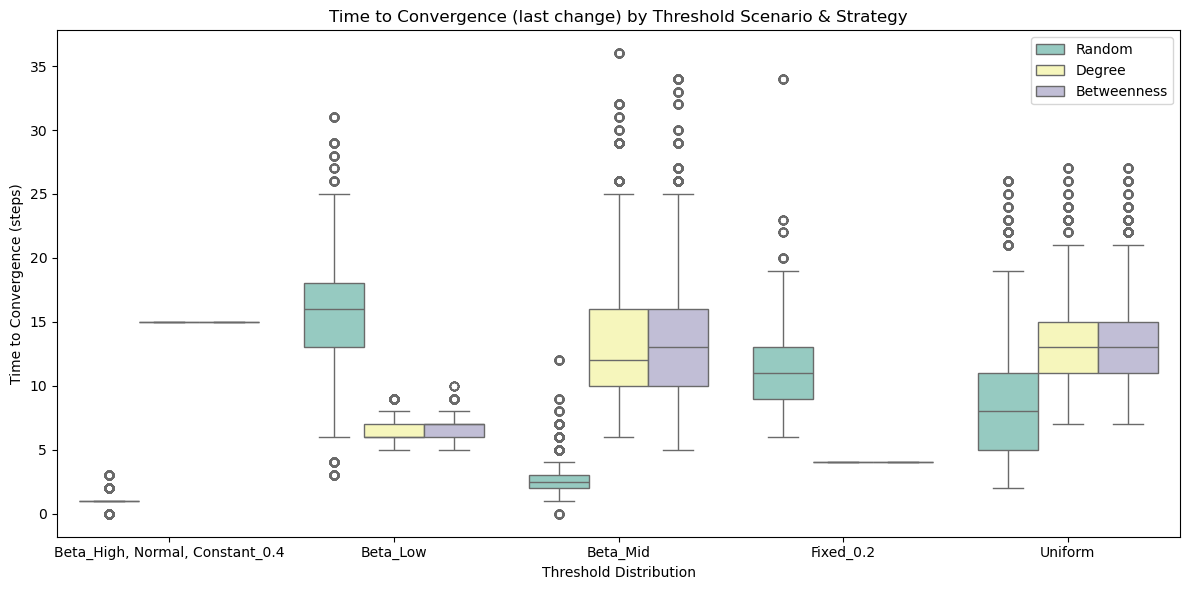

[INFO] Saved time-to-convergence plot to simulation_outputs\time_to_converge.png
[INFO] Saved summary table to simulation_outputs\summary_stats_by_strategy_threshold.csv


In [48]:
# 5. Save Raw Data + teacher-style aggregated pivots + Visualize (guarded)
if isinstance(df_results, pd.DataFrame) and not df_results.empty:
    csv_path = os.path.join(OUTPUT_DIR, RESULTS_CSV)
    df_results.to_csv(csv_path, index=False)
    print(f"[INFO] Raw data saved to {csv_path}")

    # create  aggregated summary + pivot tables
    try:
        create_summary_tables(df_results, out_dir=OUTPUT_DIR)
    except Exception as e:
        print(f"[WARN] create_summary_tables failed: {e}")

    # 6. Visualize Results
    try:
        plot_comparative_curves(df_results)
    except Exception as e:
        print(f"[WARN] plot_comparative_curves failed: {e}")
else:
    print("[WARN] No results returned from execute_experiment_suite; skipping save/plots.")

In [49]:

from IPython.display import display

csv_files = {
    'aggregated': os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold.csv"),
    'teacher_aggregated': os.path.join(OUTPUT_DIR, "aggregated_summary_by_strategy_threshold_teacherstyle.csv"),
    'summary_table': os.path.join(OUTPUT_DIR, "summary_stats_by_strategy_threshold.csv"),
    'ranking': os.path.join(OUTPUT_DIR, "ranking_by_threshold.csv"),
    'detailed': os.path.join(OUTPUT_DIR, "detailed_per_trial_summary.csv"),
    'pivot_final': os.path.join(OUTPUT_DIR, "pivot_final_adoption.csv"),
    'pivot_cascade': os.path.join(OUTPUT_DIR, "pivot_cascade_prob.csv"),
    'pivot_eff': os.path.join(OUTPUT_DIR, "pivot_efficiency.csv"),
}

print("\n[INFO] Loading saved CSV summaries from", OUTPUT_DIR)
for key, path in csv_files.items():
    if os.path.exists(path):
        try:
            df_csv = pd.read_csv(path)
            print(f"\n[INFO] {os.path.basename(path)} — rows={len(df_csv):,}, cols={len(df_csv.columns)}")
            display(df_csv.head(10))
        except Exception as e:
            print(f"[WARN] Failed reading {path}: {e}")
    else:
        print(f"[WARN] {os.path.basename(path)} not found — skipping.")
# ...existing code...


[INFO] Loading saved CSV summaries from simulation_outputs

[INFO] aggregated_summary_by_strategy_threshold.csv — rows=15, cols=10


,Strategy,Threshold_Dist,n_runs,mean_final,std_final,median_final,q25_final,q75_final,mean_time_to_conv,std_time_to_conv
0,Betweenness,"Beta_High, Normal, Constant_0.4",500,0.257500,0.000000,0.25750,0.2575,0.257500,15.000,0.000000
1,Betweenness,Beta_Low,500,0.999865,0.000360,1.00000,1.0000,1.000000,6.592,0.700369
2,Betweenness,Beta_Mid,500,0.334849,0.043110,0.32950,0.3045,0.361000,13.510,4.554051
3,Betweenness,Fixed_0.2,500,1.000000,0.000000,1.00000,1.0000,1.000000,4.000,0.000000
4,Betweenness,Uniform,500,0.493691,0.042543,0.49100,0.4640,0.524125,13.460,3.215755
5,Degree,"Beta_High, Normal, Constant_0.4",500,0.252000,0.000000,0.25200,0.2520,0.252000,15.000,0.000000
6,Degree,Beta_Low,500,0.999865,0.000360,1.00000,1.0000,1.000000,6.566,0.711799
7,Degree,Beta_Mid,500,0.337954,0.044844,0.33550,0.3060,0.362125,13.544,4.533118
8,Degree,Fixed_0.2,500,1.000000,0.000000,1.00000,1.0000,1.000000,4.000,0.000000
9,Degree,Uniform,500,0.495792,0.040811,0.49425,0.4680,0.525000,13.418,3.043320



[INFO] aggregated_summary_by_strategy_threshold_teacherstyle.csv — rows=15, cols=9


,Strategy,Threshold_Dist,n_runs,FinalAdoption,Final_STD,CascadeProb,Time50,Seeds,Efficiency
0,Betweenness,"Beta_High, Normal, Constant_0.4",500,0.257500,0.000000,0.000,15.000,20,0.012875
1,Betweenness,Beta_Low,500,0.999865,0.000360,1.000,6.592,20,0.049993
2,Betweenness,Beta_Mid,500,0.334849,0.043110,0.002,13.510,20,0.016742
3,Betweenness,Fixed_0.2,500,1.000000,0.000000,1.000,4.000,20,0.050000
4,Betweenness,Uniform,500,0.493691,0.042543,0.428,13.460,20,0.024685
5,Degree,"Beta_High, Normal, Constant_0.4",500,0.252000,0.000000,0.000,15.000,20,0.012600
6,Degree,Beta_Low,500,0.999865,0.000360,1.000,6.566,20,0.049993
7,Degree,Beta_Mid,500,0.337954,0.044844,0.002,13.544,20,0.016898
8,Degree,Fixed_0.2,500,1.000000,0.000000,1.000,4.000,20,0.050000
9,Degree,Uniform,500,0.495792,0.040811,0.442,13.418,20,0.024790



[INFO] summary_stats_by_strategy_threshold.csv — rows=15, cols=6


,Strategy,Threshold_Dist,Final_Mean,Final_STD,TimeToConv_Mean,TimeToConv_STD
0,Betweenness,"Beta_High, Normal, Constant_0.4",0.257500,0.000000,15.000000,0.000000
1,Betweenness,Beta_Low,0.999481,0.000546,6.645766,0.695213
2,Betweenness,Beta_Mid,0.334849,0.043068,13.510000,4.549585
3,Betweenness,Fixed_0.2,1.000000,0.000000,4.000000,0.000000
4,Betweenness,Uniform,0.493691,0.042501,13.460000,3.212602
5,Degree,"Beta_High, Normal, Constant_0.4",0.252000,0.000000,15.000000,0.000000
6,Degree,Beta_Low,0.999481,0.000546,6.579514,0.708616
7,Degree,Beta_Mid,0.337954,0.044800,13.544000,4.528674
8,Degree,Fixed_0.2,1.000000,0.000000,4.000000,0.000000
9,Degree,Uniform,0.495792,0.040771,13.418000,3.040336



[INFO] ranking_by_threshold.csv — rows=15, cols=10


,Strategy,Threshold_Dist,n_runs,mean_final,std_final,median_final,q25_final,q75_final,mean_time_to_conv,std_time_to_conv
0,Betweenness,"Beta_High, Normal, Constant_0.4",500,0.257500,0.000000,0.2575,0.2575,0.257500,15.000,0.000000
1,Degree,"Beta_High, Normal, Constant_0.4",500,0.252000,0.000000,0.2520,0.2520,0.252000,15.000,0.000000
2,Random,"Beta_High, Normal, Constant_0.4",500,0.012897,0.002527,0.0120,0.0110,0.014000,1.088,0.415453
3,Betweenness,Beta_Low,500,0.999865,0.000360,1.0000,1.0000,1.000000,6.592,0.700369
4,Degree,Beta_Low,500,0.999865,0.000360,1.0000,1.0000,1.000000,6.566,0.711799
5,Random,Beta_Low,500,0.950586,0.210663,1.0000,1.0000,1.000000,15.826,3.974836
6,Degree,Beta_Mid,500,0.337954,0.044844,0.3355,0.3060,0.362125,13.544,4.533118
7,Betweenness,Beta_Mid,500,0.334849,0.043110,0.3295,0.3045,0.361000,13.510,4.554051
8,Random,Beta_Mid,500,0.019351,0.006534,0.0180,0.0155,0.021500,2.754,1.340551
9,Betweenness,Fixed_0.2,500,1.000000,0.000000,1.0000,1.0000,1.000000,4.000,0.000000



[INFO] detailed_per_trial_summary.csv — rows=7,500, cols=5


,Trial,Strategy,Threshold_Dist,Final_Fraction,TimeToConverge
0,0,Random,Fixed_0.2,1.0000,11
1,0,Degree,Fixed_0.2,1.0000,4
2,0,Betweenness,Fixed_0.2,1.0000,4
3,1,Random,Fixed_0.2,1.0000,10
4,1,Degree,Fixed_0.2,1.0000,4
5,1,Betweenness,Fixed_0.2,1.0000,4
6,2,Random,Fixed_0.2,0.0695,11
7,2,Degree,Fixed_0.2,1.0000,4
8,2,Betweenness,Fixed_0.2,1.0000,4
9,3,Random,Fixed_0.2,1.0000,11



[INFO] pivot_final_adoption.csv — rows=3, cols=6


,Strategy,"Beta_High, Normal, Constant_0.4",Beta_Low,Beta_Mid,Fixed_0.2,Uniform
0,Betweenness,0.257500,0.999865,0.334849,1.000000,0.493691
1,Degree,0.252000,0.999865,0.337954,1.000000,0.495792
2,Random,0.012897,0.950586,0.019351,0.994341,0.062140



[INFO] pivot_cascade_prob.csv — rows=3, cols=6


,Strategy,"Beta_High, Normal, Constant_0.4",Beta_Low,Beta_Mid,Fixed_0.2,Uniform
0,Betweenness,0.0,1.000,0.002,1.000,0.428
1,Degree,0.0,1.000,0.002,1.000,0.442
2,Random,0.0,0.948,0.000,0.994,0.000



[INFO] pivot_efficiency.csv — rows=3, cols=6


,Strategy,"Beta_High, Normal, Constant_0.4",Beta_Low,Beta_Mid,Fixed_0.2,Uniform
0,Betweenness,0.012875,0.049993,0.016742,0.050000,0.024685
1,Degree,0.012600,0.049993,0.016898,0.050000,0.024790
2,Random,0.000645,0.047529,0.000968,0.049717,0.003107
